**This notebook generates two new features (SoF, has_blocker) and adds them to model_v1, fits a CPH model, views performance with multiple model setting**

In [59]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.spatial import distance
from scipy.spatial import cKDTree
import math
import statistics
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid', palette = 'dark')

from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import survival_difference_at_fixed_point_in_time_test
from lifelines import CoxPHFitter

from sklearn.model_selection import train_test_split
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import ConvexHull, Delaunay
from scipy.spatial.distance import euclidean

import get_data
import tackle_plot

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def plot(gameId, playId):
    game = get_data.game(gameId)
    play = get_data.play(gameId, playId)
    tracking = get_data.tracking(gameId, playId).reset_index()
    
    date = game['gameDate'].item()
    tacklers = get_data.tacklers(gameId, playId)
    carrier = play['ballCarrierId'].item()
    offense = play['possessionTeam'].item()
    defense = play['defensiveTeam'].item()
    down = play['down'].item()
    yardstogo = play['yardsToGo'].item()
    ablos = play['absoluteYardlineNumber'].item()    
    
    return tackle_plot.plot(tracking, date, tacklers, carrier, offense, defense, down, yardstogo, ablos)  

In [3]:
games_all = pd.read_csv('../rawdata/games.csv')
tackles_all = pd.read_csv('../rawdata/tackles.csv')
players_all = pd.read_csv('../rawdata/players.csv')
plays_all = pd.read_csv('../rawdata/plays.csv')

In [4]:
tracking_data = {}
for i in range(9):
    w = i + 1
    tracking_data[w] = pd.read_csv(f'../rawdata/tracking_week_{w}.csv')

### Prepare dataset

Dataset 'plays_tackle' was generated in 'data_overview', merged from play data and tackle data, only including 'pass short' play, with certain abnormal data removed.

In [5]:
plays_tackle = pd.read_csv('../newdata/plays_tackle.csv')
plays_tackle = plays_tackle.drop_duplicates(subset = ['gameId', 'playId'], keep = 'first').reset_index(drop = True)
plays_tackle.shape

(5024, 42)

## Generate new feature variables

Following the model design in 'preliminary_model', I created two new features:

- **SoF**

SoF (sum of freedom) - A measure of area to quantify how free the ball carrier can move under defense team's pressure, calculated using a Voronoi graph. In my calculation, the free area is enclosed by the Voronoi ridges between carrier and his neighbor defenders, restrained by certain boundaries. 'neighbor defenders' are identified using the Voronoi graph. Within the free area, the forward half A_fw should weigh more than the backward half A_bw. The equation of SoF is defined as: SoF = log(A_bw + 1) + A_fw. 

- **has_blocker**

has_blocker - A binary variable indicating if any offense player other than the carrier is inside the significant area. The significant area is defined by: the convex hull of the carrier and all the neighbor defenders if the defender is not behind the carrier for more than 5 yards. 5 is an arbireary choice.

In [6]:
def standardize_tracking(tracking):
    """
    Standardize data so all plays are seen as played from left to right

    Parameters:
    df1 (DataFrame): tracking data of one selected play.
    Returns:
    df1 (DataFrame): standardized tracking data of one selected play.
    """
    tracking['x'] = 120-tracking['x']
    tracking['y'] = 53.3-tracking['y']  
    tracking['dir'] = (tracking['dir'] + 180) % 360
    tracking['o'] = (tracking['o'] + 180) % 360
    return tracking

In [7]:
def get_neighbors(points, target_point):
    """
    Identify the neighboring points of a given target point within a Voronoi diagram. The neighbors are identified 
    based on the Voronoi ridges between the target point and its adjacent points.

    Args:
    points (np.ndarray): A numpy array of points [[x1, y1], [x2, y2], ...], including the target point.
    target_point (np.ndarray): A numpy array representing the target point [x, y].

    Returns:
    np.ndarray: A numpy array of the neighboring points to the target point including the target point.

    """
    target_idx = np.where((points == target_point).all(axis=1))[0][0]
    vor = Voronoi(points)
    neighbor_indices = [i for i in range(len(points)) if 
                vor.ridge_points[np.isin(vor.ridge_points, target_idx).any(1)].flatten().tolist().count(i) > 0]  
    vor_np_n = points[neighbor_indices]
    return vor_np_n

In [8]:
def order_polygon_points(points):
    """
    Order a numpy array representing a polygon's coordinates.

    Args:
    points (np.ndarray): A numpy array of points [[x1, y1], [x2, y2], ...] as the polygon's vertices.

    Returns:
    np.ndarray: The ordered coordinates of the polygon.
    """
    # Calculate centroid
    centroid_x = np.mean(points[:, 0])
    centroid_y = np.mean(points[:, 1])

    # Sort the points based on angle from centroid
    sorted_points = sorted(points, key=lambda point: math.atan2(point[1] - centroid_y, point[0] - centroid_x))

    return np.array(sorted_points)

In [9]:
def get_vertices(points, target_point):
    """
    Computes and orders the vertices of the Voronoi cell corresponding to a specified point.

    Args:
    points (np.ndarray): An ORDERED numpy array of points [[x1, y1], [x2, y2], ...] as the polygon's vertices.
    target_point (np.ndarray): A numpy array representing the target point [x, y].

    Returns:
    np.ndarray: An ordered numpy array of the vertices.
    """
    vor = Voronoi(points_nbs)    
    vertices = vor.vertices
    
    target_point_idx = np.where((points_nbs == target_point).all(axis=1))[0][0]
    region_index = vor.point_region[target_point_idx]
    region_vertices = vor.regions[region_index]
    vertices = np.array([v for i,v in enumerate(vertices) if i in region_vertices])
    vertices = order_polygon_points(vertices)
    
    return vertices    

In [10]:
def get_intersections(points, x_value):
    """
    Find the intersection points of a polygon with a vertical line x = x_value.

    Args:
    points (np.ndarray): An ORDERED numpy array of points [[x1, y1], [x2, y2], ...] as the polygon's vertices, known
    that x_value is between the min and max x values of points.
    x_value (float): The x-value of the vertical line.

    Returns:
    numpy array: The intersection points with the line x = x_value.
    """
    intersections = []

    for i in range(len(points)):
        start, end = points[i], points[(i + 1) % len(points)]

        if (start[0] <= x_value and end[0] >= x_value) or (end[0] <= x_value and start[0] >= x_value):
            if start[0] == end[0]: 
                if start[0] == x_value:
                    intersections.append([start, end])
            else:
                t = (x_value - start[0]) / (end[0] - start[0])
                y_intersect = start[1] + t * (end[1] - start[1])
                intersections.append([x_value, y_intersect])

    if len(intersections) != 2:
        raise Exception("number of intersections not equal to two")

    return np.array(intersections)

In [11]:
def calculate_area(points):
    """
    Calculate the area of a polygon given its vertices using shoelace formula.
    
    Args:
    points (np.ndarray): An ORDERED numpy array of points [[x1, y1], [x2, y2], ...] as the polygon's vertices.

    Returns:
    float: The area of the polygon.
    """
    n = len(points)  
    area = 0.0

    for i in range(n):
        j = (i + 1) % n  
        area += points[i][0] * points[j][1]
        area -= points[j][0] * points[i][1]

    area = abs(area) / 2.0
    return area

In [12]:
def get_areas(points, target_point):
    """
    Calculates the areas of the sub polygons formed by dividing a polygon with a vertical line through a given point.

    Args:
    points (np.ndarray): A numpy array of points [[x1, y1], [x2, y2], ...] as the polygon's vertices, known that 
    the target_point is within the polygon.
    target_point (np.ndarray): A numpy array representing the target point [x, y].

    Returns:
    tuple: A tuple containing the area of the left polygon, the area of the right polygon, 
           vertices of the left polygon, and vertices of the right polygon.
    """
    intersections =  get_intersections(points, target_point[0])
    
    points_right = np.array([p for p in points if p[0] > target_point[0]])
    points_right = np.vstack([points_right, intersections])
    points_right = order_polygon_points(points_right)
    area_right = calculate_area(points_right)
    
    points_left = np.array([p for p in points if p[0] < target_point[0]])
    points_left = np.vstack([points_left, intersections])
    points_left = order_polygon_points(points_left)
    area_left = calculate_area(points_left)    
    
    return area_left, area_right, points_left, points_right

In [13]:
def check_blocker(hull_points, checked_points):
    """
    Determines if any points in a set of checked_points lie within the convex hull defined by another set of points.

    Parameters:
    hull_points (np.ndarray): An array of points [[x1, y1], [x2, y2], ...] used to construct the convex hull.
    checked_points (np.ndarray): A numpy array of points [[x1, y1], [x2, y2], ...]
    
    Returns:
    bool: True if any of the checked_points lie within the convex hull, False otherwise.
    """
    #returns False if there are less than three unique points in 'hull_points', as a convex hull cannot be formed.
    if len(np.unique(hull_points, axis=0)) < 3:
        return False

    hull = ConvexHull(hull_points)
    tri = Delaunay(hull_points[hull.vertices])
    return any(np.array([tri.find_simplex(p) >=0 for p in checked_points]))

In [14]:
def plot_polygon(coordinates, color='grey', alpha = 0.5):
    '''
    Fill a polygon in a plot.
    '''
    x, y = zip(*coordinates)
    x += (x[0],)
    y += (y[0],)

    plt.fill(x, y, color=color, alpha=alpha) 

In [47]:
def plot_vor(points_nbs, hull_points, carrier_caught_xy, boundary_points, vertices, 
             vertices_left, vertices_right, offense_caught_xy_n):
    """
    Creates a plot of a Voronoi diagram with additional features including hulls, carriers, boundaries, and vertices.

    Args:
    points_nbs (np.ndarray): An array of points used to generate the Voronoi diagram.
    hull_points (np.ndarray): Points used to create a convex hull, if possible.
    carrier_caught_xy (np.ndarray): The position of the ball carrier.
    boundary_points (np.ndarray): Points that define the boundary of the area of interest.
    vertices (np.ndarray): Vertices of the Voronoi cell associated with the ball carrier.
    vertices_left (np.ndarray): Vertices of the left section of the divided Voronoi cell.
    vertices_right (np.ndarray): Vertices of the right section of the divided Voronoi cell.
    offense_caught_xy_n (np.ndarray): Positions of the offenders.

    Returns:
    None: The function creates and displays a plot.
    """
    fig, ax = plt.subplots(figsize = (6,6))
    
    vor = Voronoi(points_nbs)
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='dimgrey', line_width=1)
    
    # Separate defender points from carrier and boundary points
    defense_nbs_xy = np.array([p for i, p in enumerate(points_nbs) if 
                      not np.any((p == np.vstack([boundary_points, carrier_caught_xy])).all(axis = 1))])
    
    points_plot = np.vstack([vertices, defense_nbs_xy])
    max_y = np.max(points_plot[:, 1])
    min_y = np.min(points_plot[:, 1])
    max_x = np.max(points_plot[:, 0])
    min_x = np.min(points_plot[:, 0])
    
    ylim_top = max_y + 5 if max_y <= 48.3 else 53.3
    ylim_bot = min_y - 5 if min_y >= 5 else 0

    plt.plot(defense_nbs_xy[:, 0], defense_nbs_xy[:, 1], 'o', color = 'darkblue', label = 'defenders')
    plt.plot(carrier_caught_xy[0], carrier_caught_xy[1], 'o', color = 'sienna', label = 'ball carrier')   
    plt.plot(boundary_points[:, 0], boundary_points[:, 1], 'o', color = 'lightgrey')  
    plt.plot(vertices[:, 0], vertices[:, 1], 'o', color = 'black', markersize = 3)
    plt.plot(offense_caught_xy_n[:, 0], offense_caught_xy_n[:, 1], 'o', color = 'peru', 
             markersize = 3.5, label = 'offenders')

    if len(np.unique(hull_points, axis=0)) >= 3:
        hull = ConvexHull(hull_points)      
        for simplex in hull.simplices:
            plt.plot(hull_points[simplex, 0], hull_points[simplex, 1], linestyle=':', color = 'grey')
    
    plot_polygon(vertices_right, alpha = 0.5)
    plot_polygon(vertices_left, alpha = 0.2)
    
    ax.set_ylim(ylim_bot, ylim_top)
    ax.set_xlim(min_x-5, max_x+5)
    ax.set_aspect('equal')
    ax.grid(False) 
    
    plt.legend(bbox_to_anchor =(1.02, 0.8), loc='upper left') 
    plt.show()

Sample graphs:
gameId:2022100908, playId:3537, has_blocker:False
area_left: 15.36, log(area_left+1): 2.79, area_right: 23.85, SoF: 26.64


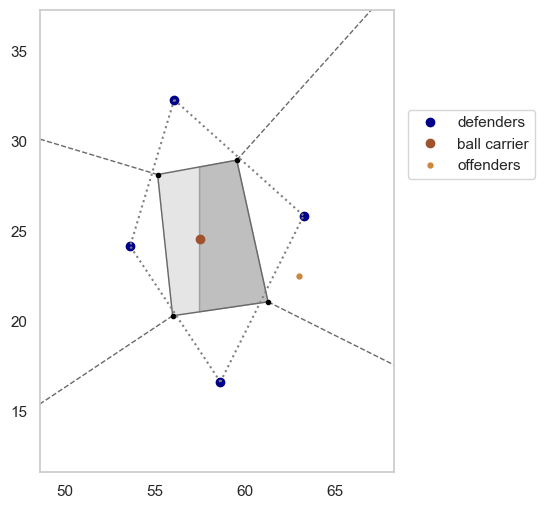

gameId:2022091111, playId:1148, has_blocker:False
area_left: 16.47, log(area_left+1): 2.86, area_right: 11.15, SoF: 14.02


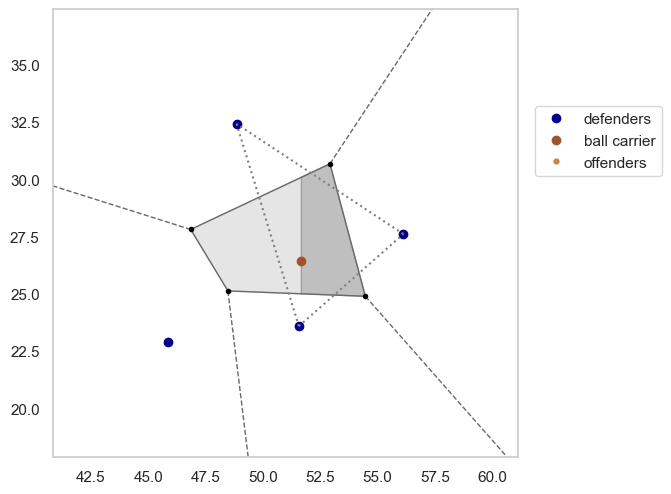

gameId:2022103001, playId:2165, has_blocker:True
area_left: 445.2, log(area_left+1): 6.1, area_right: 180.18, SoF: 186.28


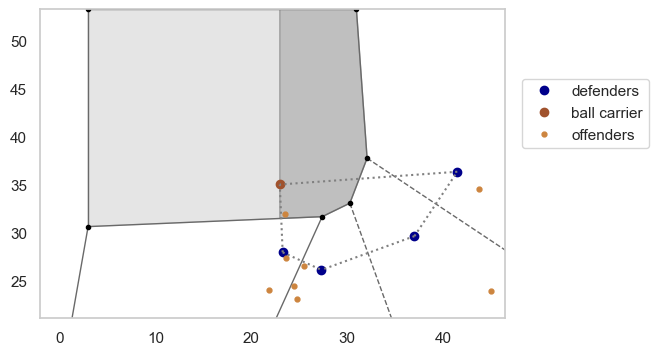

gameId:2022092511, playId:2903, has_blocker:True
area_left: 255.73, log(area_left+1): 5.55, area_right: 12.8, SoF: 18.35


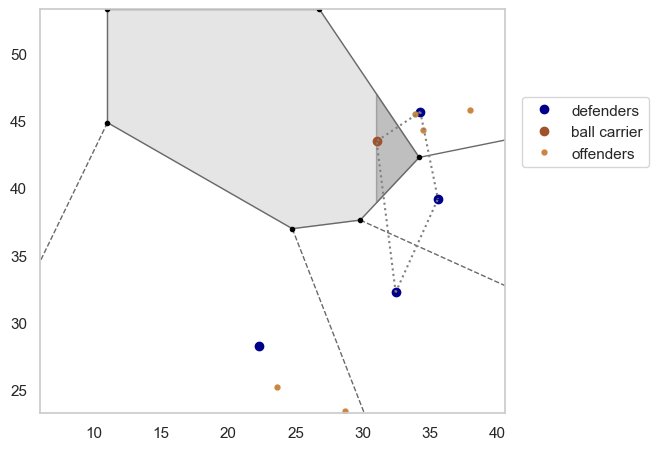

gameId:2022091102, playId:3336, has_blocker:False
area_left: 0.84, log(area_left+1): 0.61, area_right: 7.97, SoF: 8.58


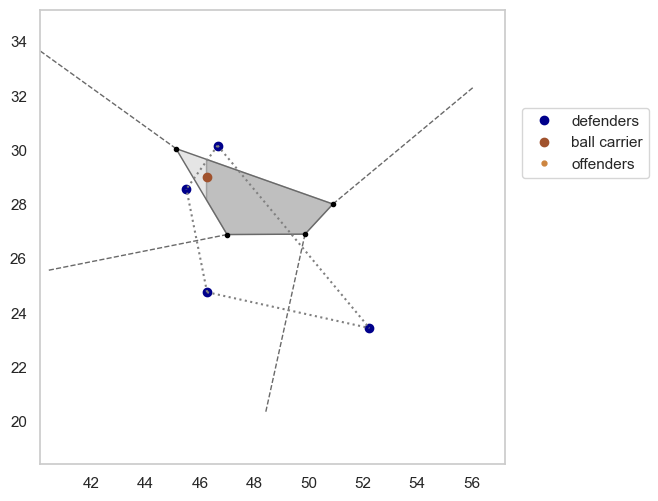

gameId:2022100212, playId:1183, has_blocker:True
area_left: 52.39, log(area_left+1): 3.98, area_right: 15.11, SoF: 19.09


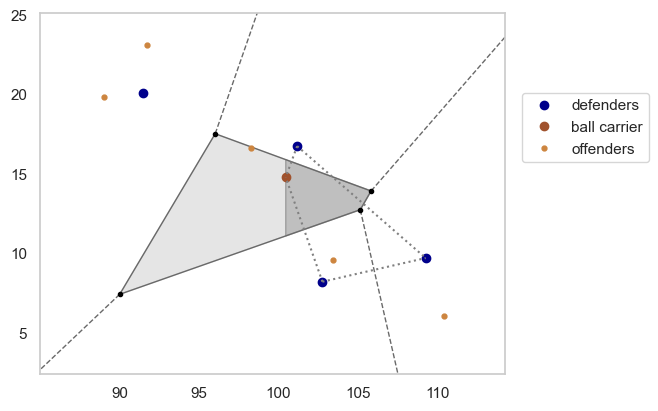

gameId:2022102303, playId:1895, has_blocker:False
area_left: 5.7, log(area_left+1): 1.9, area_right: 24.8, SoF: 26.7


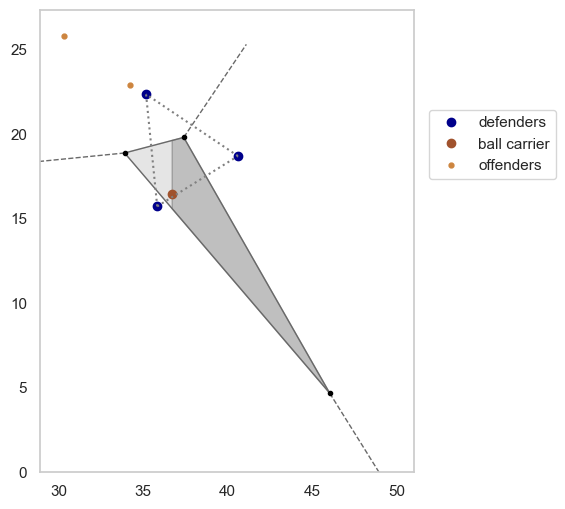

gameId:2022110603, playId:3498, has_blocker:False
area_left: 291.51, log(area_left+1): 5.68, area_right: 7.66, SoF: 13.34


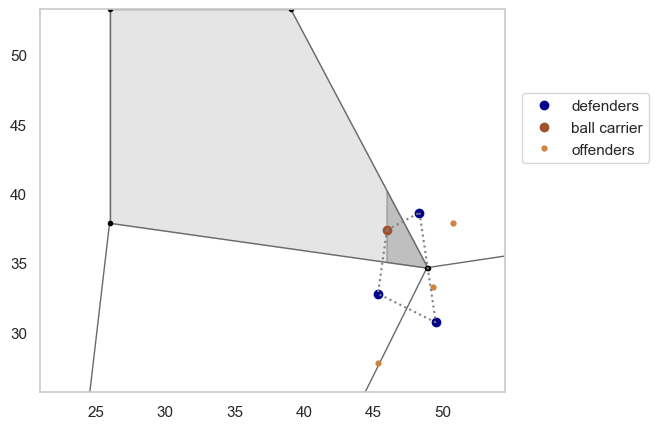

gameId:2022100211, playId:1790, has_blocker:True
area_left: 264.24, log(area_left+1): 5.58, area_right: 21.86, SoF: 27.44


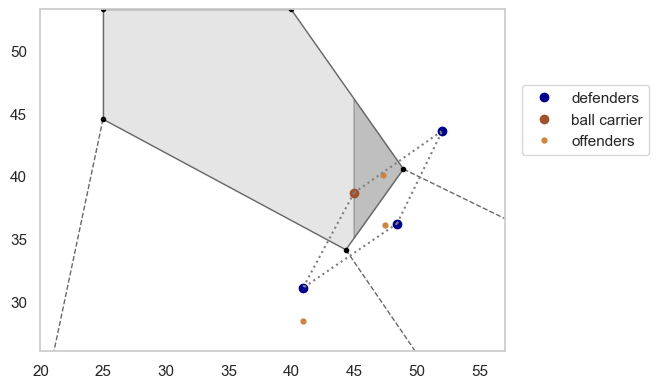

gameId:2022102305, playId:1996, has_blocker:False
area_left: 85.43, log(area_left+1): 4.46, area_right: 20.56, SoF: 25.02


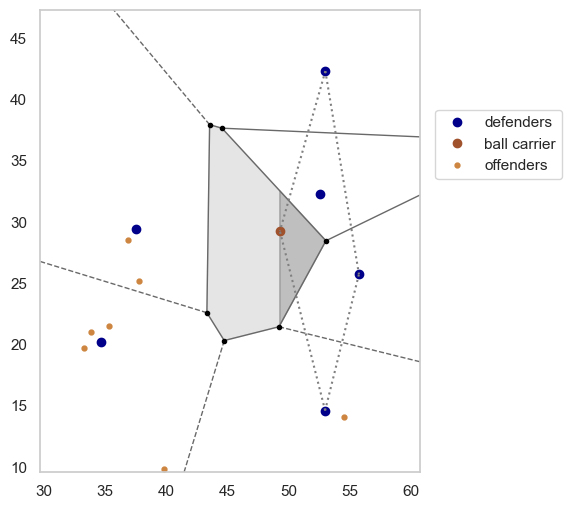

gameId:2022091109, playId:1705, has_blocker:False
area_left: 216.37, log(area_left+1): 5.38, area_right: 46.02, SoF: 51.4


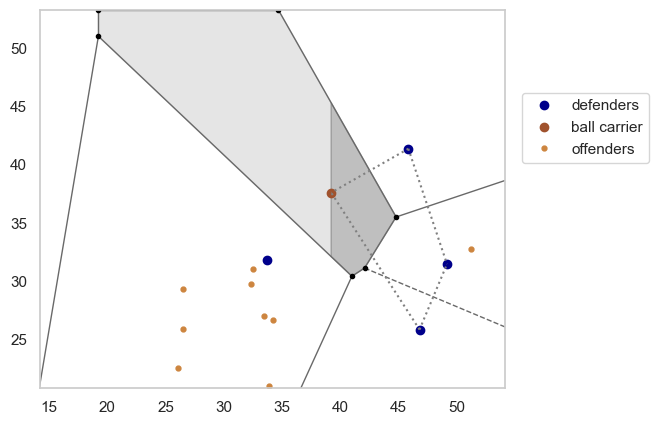

CPU times: total: 1min 13s
Wall time: 57 s


In [48]:
%%time
freedom_data = []
print('Sample graphs:')

for idx, row in plays_tackle.iterrows():
    gameId, playId = row['gameId'], row['playId']
    game_week = games_all[games_all['gameId'] == gameId]['week'].item()
    carrier = row['ballCarrierId']
    offense = row['possessionTeam']
    defense = row['defensiveTeam']
    
    tracking_w = tracking_data[game_week]
    tracking = tracking_w[(tracking_w['gameId'] == gameId) & (tracking_w['playId'] == playId)].reset_index(drop = True)
    if tracking.at[0, 'playDirection'] == 'left':
        tracking = standardize_tracking(tracking)
    
    caught_frm = 6
    # Note the special case
    if gameId == 2022110608 and playId == 2351:
        caught_frm = 32
        
    caught_df = tracking[tracking['frameId'] == caught_frm]
    
    defense_caught_df = caught_df[caught_df['club'] == defense].reset_index(drop = True)
    defense_caught_xy = defense_caught_df[['x', 'y']].to_numpy()
    
    carrier_caught_df = caught_df[caught_df['nflId'] == carrier]
    carrier_caught_xy = carrier_caught_df[['x', 'y']].to_numpy()[0]

    # Set boundary points to avoid unbounded vertices. The points are either mirrored from carrier across 
    # the sidelines or 40 yards from the carrier on both xy directions.
    boundary_points = np.array(
        [[carrier_caught_xy[0], 53.3+(53.3-carrier_caught_xy[1])], 
         [carrier_caught_xy[0], 0-carrier_caught_xy[1]],
         [carrier_caught_xy[0], carrier_caught_xy[1]+40],
         [carrier_caught_xy[0], carrier_caught_xy[1]-40],
         [carrier_caught_xy[0] - 40, carrier_caught_xy[1]], 
         [carrier_caught_xy[0] + 40, carrier_caught_xy[1]]] ) 
    
    points = np.vstack([defense_caught_xy, carrier_caught_xy, boundary_points])
    
    # Get neighbor defenders from all points
    points_nbs = get_neighbors(points, carrier_caught_xy)
    vertices = get_vertices(points_nbs, carrier_caught_xy)
    
    # Get areas and calculate SoF
    area_left, area_right, vertices_left, vertices_right = get_areas(vertices, carrier_caught_xy) 
    log_area_left = np.log(area_left+1)
    SoF = log_area_left + area_right
    
    # Get offense players other than the carrier
    offense_caught_df = caught_df[caught_df['club'] == offense].reset_index(drop = True)
    offense_caught_xy = offense_caught_df[['x', 'y']].to_numpy()   
    offense_caught_xy_n = np.array([p for i, p in enumerate(offense_caught_xy) if np.any(p != carrier_caught_xy)])    
    
    # Get defender points which are not 5 yards behind carrier    
    hull_points = np.array([p for i, p in enumerate(points_nbs) if 
                  not np.any((p == boundary_points).all(axis = 1))          
                  and p[0] > carrier_caught_xy[0] - 5])
    
    # # Get the binary variable has_blocker
    has_blocker = check_blocker(hull_points, offense_caught_xy_n)
    
    freedom_data.append({'gameId':gameId, 'playId':playId, 'area_left':area_left, 'log_area_left': log_area_left,
                            'area_right': area_right, 'SoF': SoF, 'has_blocker': has_blocker})
    
    # Display sample graphs
    if idx <=10:
        print(f'gameId:{gameId}, playId:{playId}, has_blocker:{has_blocker}')
        print(f'area_left: {area_left.round(2)}, log(area_left+1): {log_area_left.round(2)}, area_right: {area_right.round(2)}, SoF: {SoF.round(2)}')
        plot_vor(points_nbs, hull_points, carrier_caught_xy, boundary_points, vertices, 
             vertices_left, vertices_right, offense_caught_xy_n)

freedom_df = pd.DataFrame(freedom_data)

In [17]:
freedom_df['has_blocker'] = freedom_df['has_blocker'].apply(lambda x: 1 if x == True else 0)

In [18]:
freedom_df.describe()

,gameId,playId,area_left,log_area_left,area_right,SoF,has_blocker
count,5.024000e+03,5024.000000,5024.000000,5024.000000,5024.000000,5024.000000,5024.000000
mean,2.022099e+09,1997.484275,151.114362,4.538508,34.555690,39.094197,0.221139
std,5.938008e+03,1180.772543,118.618340,1.178605,37.499399,37.712023,0.415055
min,2.022091e+09,54.000000,0.083959,0.080620,0.203140,2.228922,0.000000
25%,2.022092e+09,972.500000,40.135183,3.716864,11.035319,15.484145,0.000000
50%,2.022101e+09,1975.500000,135.538138,4.916604,23.207911,27.856244,0.000000
75%,2.022102e+09,3001.000000,239.533605,5.482860,44.241730,49.281764,0.000000
max,2.022111e+09,5096.000000,578.499025,6.362164,465.962703,471.181825,1.000000


## Combine all variables and fit CPH model

In [19]:
progress_df2 = pd.read_csv('../newdata/progress_df2.csv')

In [20]:
progress_df2.shape

(5024, 10)

In [21]:
progress_df3 = pd.merge(progress_df2, freedom_df[['gameId', 'playId', 'SoF', 'has_blocker']], 
                     on = ['gameId', 'playId'], how = 'left')

In [22]:
progress_df3.head()

,gameId,playId,progress,lst_event,near_defender,near_defender_MPD,near_dist,leverage,caught_width,caught_x,SoF,has_blocker
0,2022100908,3537,2.340000,1,43306.0,0.318461,3.881714,0,2.07,57.560001,26.639809,0
1,2022091111,1148,2.779999,1,47843.0,0.831594,2.832137,1,0.23,51.650002,14.015269,0
2,2022103001,2165,9.760002,1,46205.0,3.444545,7.086353,0,18.29,23.480000,186.281002,1
3,2022092511,2903,6.030006,1,52527.0,2.751467,3.919005,0,9.83,31.449997,18.348826,1
4,2022091102,3336,0.777499,1,46077.0,0.735391,0.860930,0,24.29,48.610001,8.584447,0


In [23]:
#progress_df3.to_csv('../newdata/progress_df3.csv', index = False)

In [24]:
model_df = progress_df3[['lst_event', 'progress', 'near_defender_MPD', 'near_dist', 
                         'leverage', 'caught_width', 'SoF', 'has_blocker']]

In [60]:
scaler = StandardScaler()
standardized_df = pd.DataFrame(scaler.fit_transform(model_df), columns = model_df.columns)
standardized_df.cov()

,lst_event,progress,near_defender_MPD,near_dist,leverage,caught_width,SoF,has_blocker
lst_event,1.000199,-0.141054,-0.049681,-0.020245,-0.004592,-0.010591,-0.079944,-0.018003
progress,-0.141054,1.000199,0.420661,0.428068,-0.058133,-0.005994,0.361673,0.298290
near_defender_MPD,-0.049681,0.420661,1.000199,0.511977,-0.060021,-0.020775,0.325232,0.239871
near_dist,-0.020245,0.428068,0.511977,1.000199,-0.058576,-0.005997,0.446050,0.222645
leverage,-0.004592,-0.058133,-0.060021,-0.058576,1.000199,-0.007269,-0.162027,0.018948
caught_width,-0.010591,-0.005994,-0.020775,-0.005997,-0.007269,1.000199,-0.020872,-0.032538
SoF,-0.079944,0.361673,0.325232,0.446050,-0.162027,-0.020872,1.000199,0.083674
has_blocker,-0.018003,0.298290,0.239871,0.222645,0.018948,-0.032538,0.083674,1.000199


In [25]:
mask = np.random.rand(len(model_df)) < 0.75
df_train = model_df[mask]
df_test = model_df[~mask]

In [26]:
cph_model = CoxPHFitter()
cph_model.fit(df=df_train, duration_col='progress', event_col='lst_event')
cph_model.print_summary()

<lifelines.CoxPHFitter: fitted with 3754 total observations, 92 right-censored observations>
             duration col = 'progress'
                event col = 'lst_event'
      baseline estimation = breslow
   number of observations = 3754
number of events observed = 3662
   partial log-likelihood = -25800.44
         time fit was run = 2024-01-06 15:40:19 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
near_defender_MPD  -0.13       0.88       0.01            -0.15            -0.11                 0.86                 0.90
near_dist          -0.11       0.89       0.01            -0.13            -0.09                 0.88                 0.91
leverage           -0.06       0.94       0.04            -0.13             0.01                 0.88                 1.01
caught_width       -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
SoF                -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
has_blocker        -0.54       0.58       0.04            -0.63            -0.46                 0.54                 0.63

                    cmp to      z      p   -log2(p)
covariate                                          
near_defender_MPD     0.00 -11.89 <0.005     105.91
near_dist             0.00 -11.91 <0.005     106.18
leverage              0.00  -1.71   0.09       3.53
caught_width          0.00  -0.52   0.61       0.72
SoF                   0.00 -11.46 <0.005      98.62
has_blocker           0.00 -13.06 <0.005     127.00
---
Concordance = 0.75
Partial AIC = 51612.89
log-likelihood ratio test = 1470.95 on 6 df
-log2(p) of ll-ratio test = inf

The model summary suggests that:
    
- Indicated by high '-log2(p)' value and low p-value, features 'near_defender_MPD', 'near_dist', 'SoF', and 'has_blocker' all have a significant negative impact on the hazard (occurrence of a dead ball). Negative coef indicates that as the values of these variables increase, the likelihood of the event happening decreases.   

- 'Leverage' and 'caught_with' do not show a statistically significant effect.

- The concordance index of 0.75 suggests the model has good yet not perfect predictive power. 

- the high overall -log2(p) suggests the overall model is statistically significant.

<Axes: xlabel='log(HR) (95% CI)'>

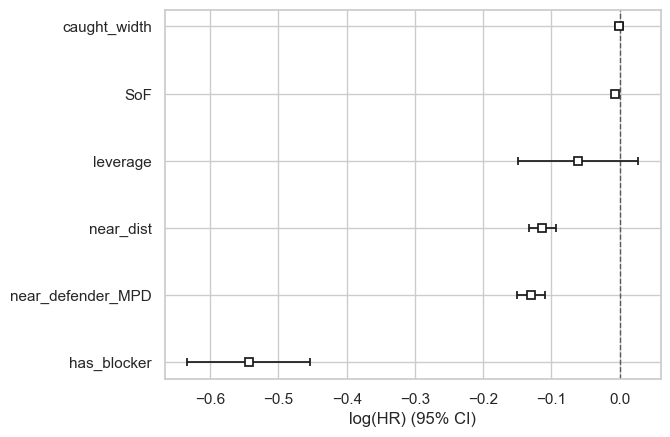

In [28]:
cph_model.plot()

In [29]:
model_df['leverage'].value_counts()

leverage
0    3215
1    1809
Name: count, dtype: int64

In [30]:
model_df[['near_defender_MPD', 'near_dist', 'leverage', 'caught_width', 'SoF']].cov()

,near_defender_MPD,near_dist,leverage,caught_width,SoF
near_defender_MPD,4.156261,2.567403,-0.058731,-0.290284,24.999874
near_dist,2.567403,6.052818,-0.069170,-0.101130,41.376655
leverage,-0.058731,-0.069170,0.230466,-0.023918,-2.932802
caught_width,-0.290284,-0.101130,-0.023918,46.993859,-5.394759
SoF,24.999874,41.376655,-2.932802,-5.394759,1422.196649


In [53]:
quartiles = model_df[['near_defender_MPD', 'near_dist', 'caught_width', 'SoF']].quantile([0.05, 0.50, 0.95]).round(2)

In [54]:
quartiles

,near_defender_MPD,near_dist,caught_width,SoF
0.05,0.08,0.56,2.23,7.17
0.50,0.76,3.01,13.32,27.86
0.95,6.07,8.16,24.66,109.02


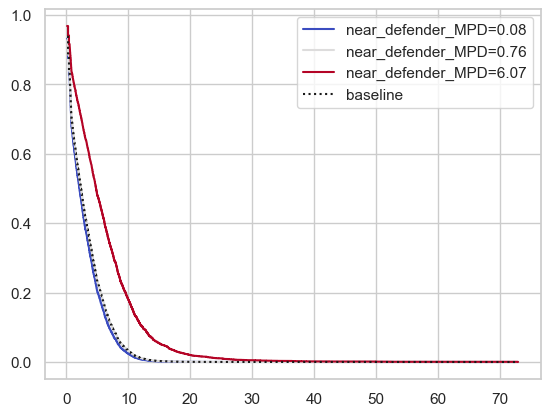

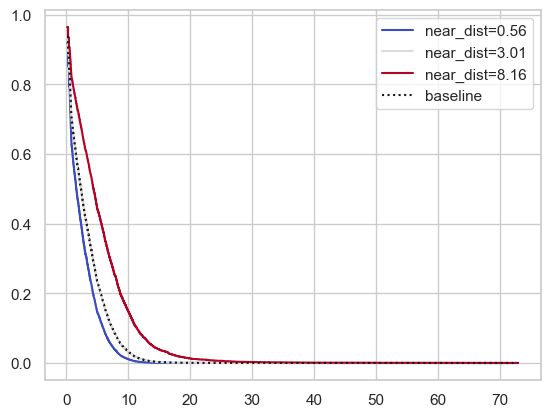

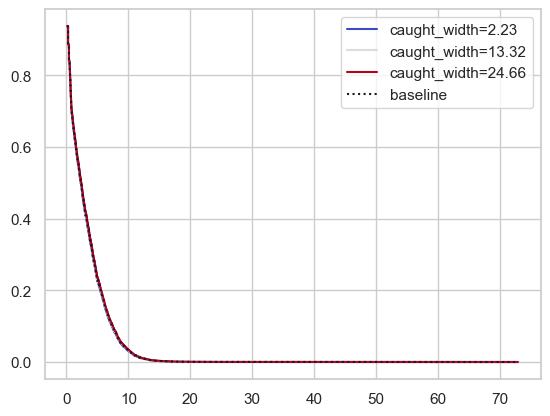

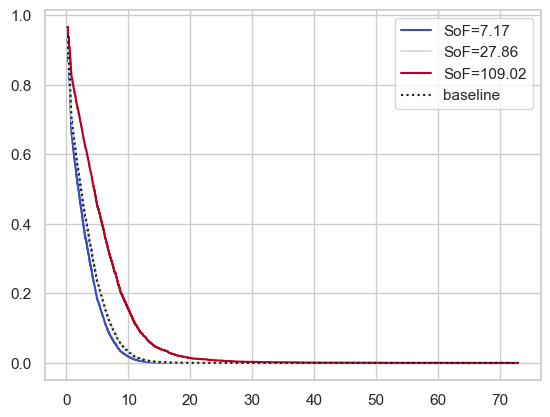

In [55]:
for col in quartiles.columns:
    cph_model.plot_partial_effects_on_outcome(covariates = col, values = quartiles[col].tolist(), cmap = 'coolwarm')   

<Axes: >

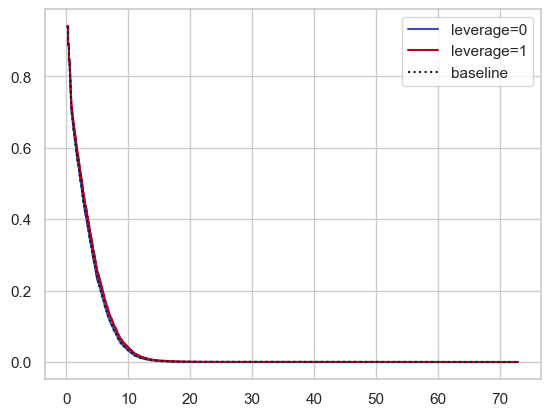

In [56]:
cph_model.plot_partial_effects_on_outcome(covariates = 'leverage', values = [0,1], cmap = 'coolwarm')

<Axes: >

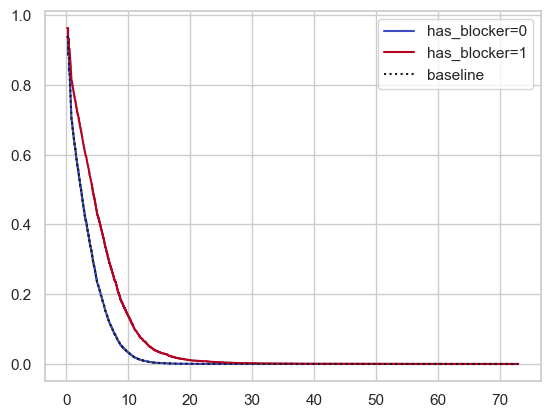

In [57]:
cph_model.plot_partial_effects_on_outcome(covariates = 'has_blocker', values = [0,1], cmap = 'coolwarm')

## Compare predicted probability distribution and rsme between different model setting

The survival analysis models were designed to generate survival functions, which predict the probability of event occurrence not before certain durations. To understand the prediction pattern of fitted models, I set the model to generate a survival function for each case in the test data, and then from the survival function retrieved the probability of the play achieving the true progress from data. The model's prediction pattern can be viewed from the distribution of predicted probability. Meanwhile, although CoxPH model is not typically used for predicting the exact survival duration, it can provided predicted duration as a side reference.

In [36]:
def fit_predict(model_df, robust = False):
    '''
    Trains a Cox Proportional Hazards model on specified dataset, evaluates its performance on a test set, 
    and visualizes the results.

    Args:
    - model_df (DataFrame): The input dataframe for modeling.
    - robust (bool, optional): If True, a robust fitting approach is used. Default is False.
    '''    
    
    mask = np.random.rand(len(model_df)) < 0.75
    df_train = model_df[mask]
    df_test = model_df[~mask].reset_index(drop = True)
    
    cph_model = CoxPHFitter()
    cph_model.fit(df=df_train, duration_col='progress', event_col='lst_event', robust = robust)
    cph_model.print_summary()
    
    df_predict = predict_prob_cph(cph_model, df_test)
    plot_prob(df_predict)
    
    # Predict progress and plot error
    df_predict['ex_progress'] = cph_model.predict_expectation(df_test)
    df_predict['error'] = df_predict['ex_progress'] - df_predict['progress']
    rmse = np.sqrt(mean_squared_error(df_predict['progress'], df_predict['ex_progress']))
    print(f'rmse: {rmse}')
    plt.figure(figsize=(12, 3))
    sns.scatterplot(data = df_predict, x = 'progress', y = 'error', s = 5)
    plt.show()

In [61]:
def plot_prob(df_predict):
    '''
    Generates two plots to visualize the predicted probabilities: a histogram and a scatter plot.

    Args:
    - df_predict (DataFrame): The dataframe containing the 'Predicted_Probability' and 'progress' columns.
    '''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 5]})

    # Histogram of Predicted Probabilities
    n, bins, patches = ax1.hist(df_predict['Predicted_Probability'], bins=6, alpha=0.7)
    ax1.set_title('Histogram of Predicted Probabilities')
    ax1.set_xlabel('Predicted Probability')
    ax1.set_ylabel('Frequency')

    for i in range(len(patches)):
        ax1.text(patches[i].xy[0] + patches[i].get_width() / 2, patches[i].get_height(), 
                 f'{n[i]/len(df_predict):.2f}', ha='center', va='bottom')
        
    # Scatter Plot of Predicted Probabilities vs Progress
    sns.scatterplot(data=df_predict, x='progress', y='Predicted_Probability', s=5, ax=ax2)
    ax2.set_title('CPH Model - Scatter Plot of Predicted Probabilities vs Progress')
    ax2.set_xlabel('Progress')
    ax2.set_ylabel('Predicted Probability')
    
    ax2.set_xticks(np.arange(0, max(df_predict.progress), 5))

    plt.tight_layout()
    plt.show()

In [38]:
def predict_prob_cph(model, df_test):
    '''
    Generates predicted probabilities for a test dataset using a Cox Proportional Hazards model.

    Args:
    - model (CoxPHFitter object): The fitted Cox Proportional Hazards model.
    - df_test (DataFrame): The test dataframe containing the features and 'progress' column.

    Returns:
    DataFrame: A copy of the test dataframe with an additional 'Predicted_Probability' column, 
               containing the predicted probabilities rounded to two decimal places.    
    '''
    df_predict = df_test.copy()
    predictions = []
    for index, row in df_predict.iterrows():

        progress = math.floor(row['progress']*10)/10
        data = row.drop(['progress', 'lst_event'])  

        survival_function = model.predict_survival_function(data)
        progress = survival_function.index[abs(progress - survival_function.index).argmin()]

        predicted_probability = survival_function.loc[progress, index]
        predictions.append(predicted_probability)

    df_predict['Predicted_Probability'] = predictions
    df_predict['Predicted_Probability'] = df_predict['Predicted_Probability'].round(2)   
    return df_predict

<lifelines.CoxPHFitter: fitted with 3765 total observations, 91 right-censored observations>
             duration col = 'progress'
                event col = 'lst_event'
      baseline estimation = breslow
   number of observations = 3765
number of events observed = 3674
   partial log-likelihood = -25971.80
         time fit was run = 2024-01-07 00:59:52 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
near_defender_MPD  -0.13       0.88       0.01            -0.15            -0.11                 0.86                 0.90
near_dist          -0.11       0.90       0.01            -0.13            -0.09                 0.88                 0.91
leverage           -0.08       0.92       0.04            -0.15            -0.01                 0.86                 0.99
caught_width       -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
SoF                -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
has_blocker        -0.53       0.59       0.04            -0.62            -0.45                 0.54                 0.64

                    cmp to      z      p   -log2(p)
covariate                                          
near_defender_MPD     0.00 -11.80 <0.005     104.40
near_dist             0.00 -11.92 <0.005     106.44
leverage              0.00  -2.36   0.02       5.77
caught_width          0.00  -2.19   0.03       5.14
SoF                   0.00 -10.96 <0.005      90.51
has_blocker           0.00 -12.77 <0.005     121.69
---
Concordance = 0.75
Partial AIC = 51955.59
log-likelihood ratio test = 1363.10 on 6 df
-log2(p) of ll-ratio test = 965.44

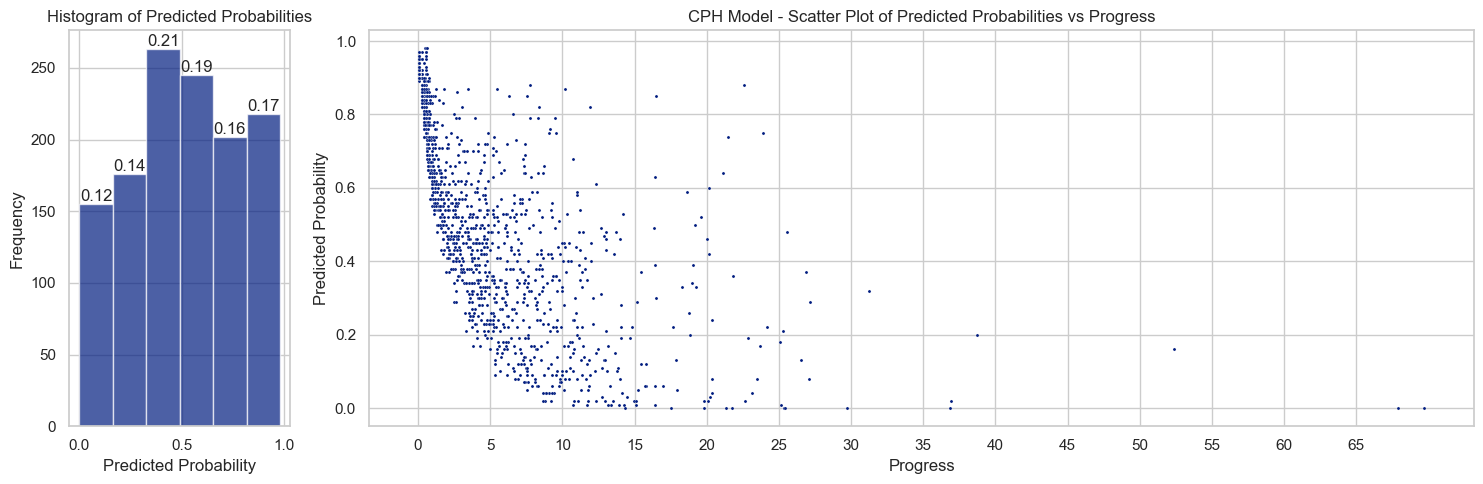

rmse: 6.795136825265243


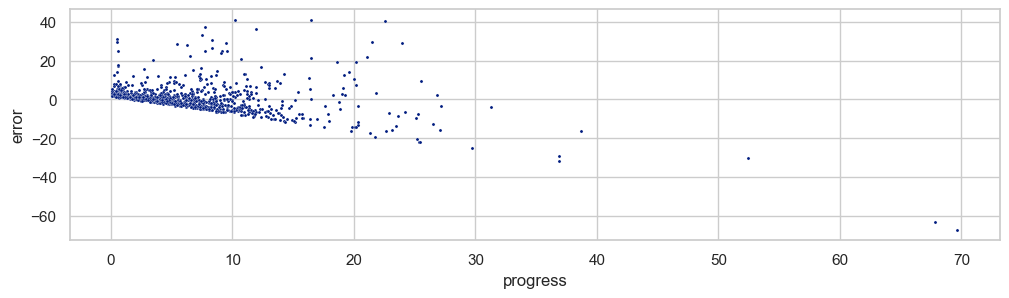

In [62]:
fit_predict(model_df, robust = False)

<lifelines.CoxPHFitter: fitted with 3722 total observations, 86 right-censored observations>
             duration col = 'progress'
                event col = 'lst_event'
          robust variance = True
      baseline estimation = breslow
   number of observations = 3722
number of events observed = 3636
   partial log-likelihood = -25664.44
         time fit was run = 2024-01-06 15:43:40 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
near_defender_MPD  -0.13       0.88       0.01            -0.15            -0.11                 0.86                 0.90
near_dist          -0.10       0.90       0.01            -0.12            -0.08                 0.89                 0.92
leverage            0.03       1.03       0.04            -0.06             0.12                 0.94                 1.12
caught_width       -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
SoF                -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
has_blocker        -0.51       0.60       0.04            -0.59            -0.42                 0.55                 0.65

                    cmp to      z      p   -log2(p)
covariate                                          
near_defender_MPD     0.00 -12.23 <0.005     111.76
near_dist             0.00  -9.99 <0.005      75.71
leverage              0.00   0.66   0.51       0.97
caught_width          0.00  -1.11   0.27       1.90
SoF                   0.00  -9.08 <0.005      63.01
has_blocker           0.00 -11.68 <0.005     102.36
---
Concordance = 0.75
Partial AIC = 51340.89
log-likelihood ratio test = 1370.00 on 6 df
-log2(p) of ll-ratio test = 970.40

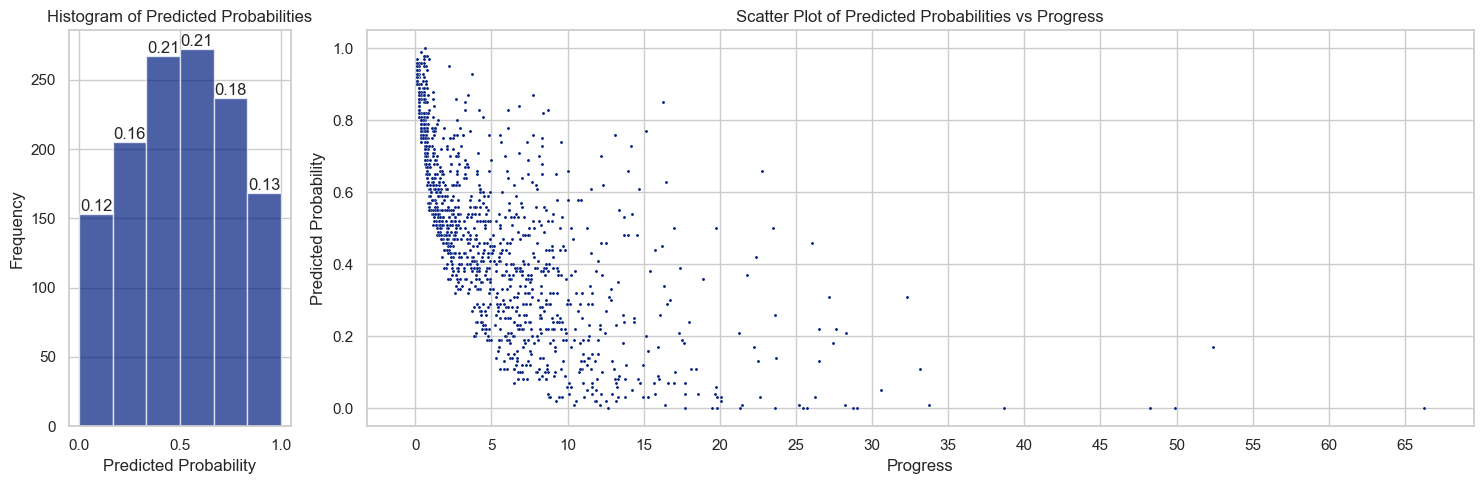

rmse: 7.203050870626458


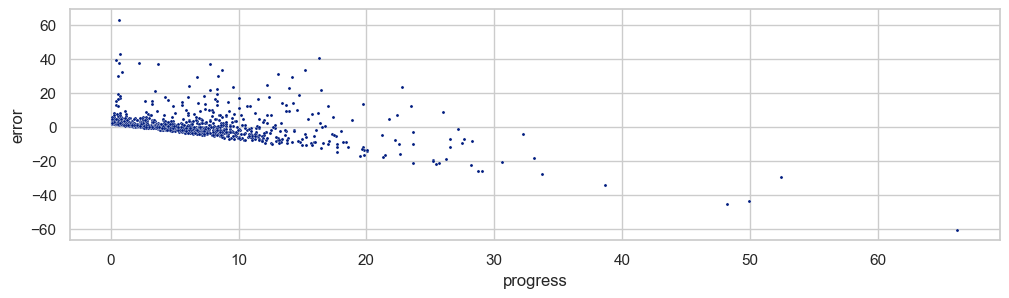

In [44]:
fit_predict(model_df, robust = True)

<lifelines.CoxPHFitter: fitted with 3785 total observations, 98 right-censored observations>
             duration col = 'progress'
                event col = 'lst_event'
      baseline estimation = breslow
   number of observations = 3785
number of events observed = 3687
   partial log-likelihood = -26070.23
         time fit was run = 2024-01-06 15:44:19 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
near_defender_MPD  -0.13       0.88       0.01            -0.15            -0.11                 0.86                 0.90
near_dist          -0.12       0.89       0.01            -0.13            -0.10                 0.87                 0.91
SoF                -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
has_blocker        -0.51       0.60       0.04            -0.59            -0.43                 0.55                 0.65

                    cmp to      z      p   -log2(p)
covariate                                          
near_defender_MPD     0.00 -12.00 <0.005     107.81
near_dist             0.00 -12.44 <0.005     115.67
SoF                   0.00 -11.17 <0.005      93.88
has_blocker           0.00 -12.23 <0.005     111.90
---
Concordance = 0.75
Partial AIC = 52148.45
log-likelihood ratio test = 1408.75 on 4 df
-log2(p) of ll-ratio test = 1006.73

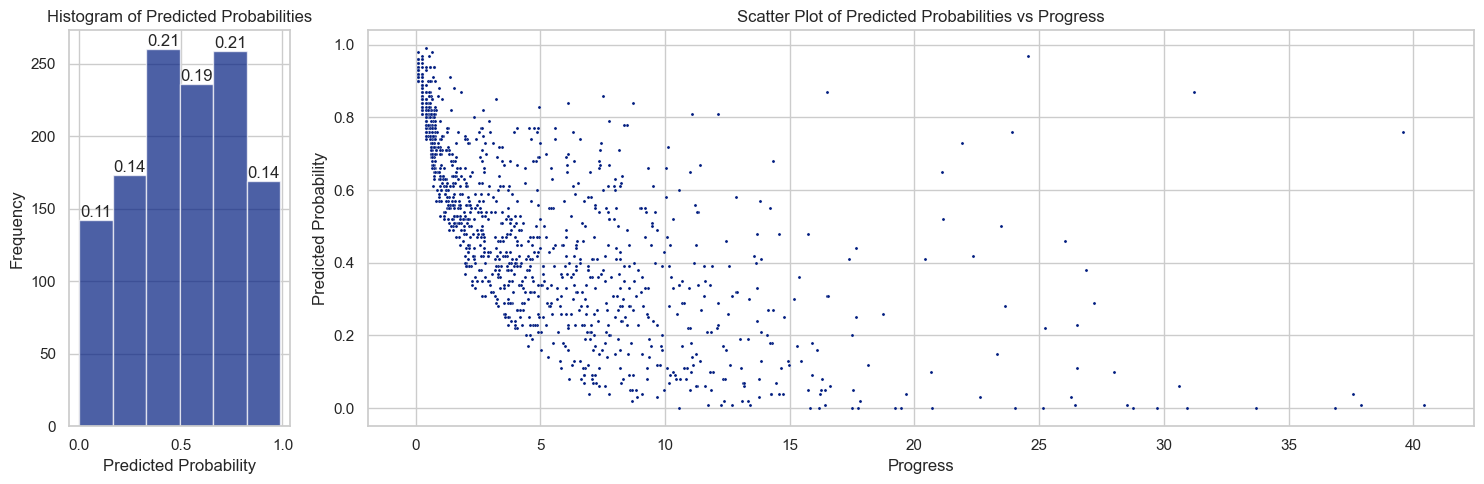

rmse: 6.575304163191846


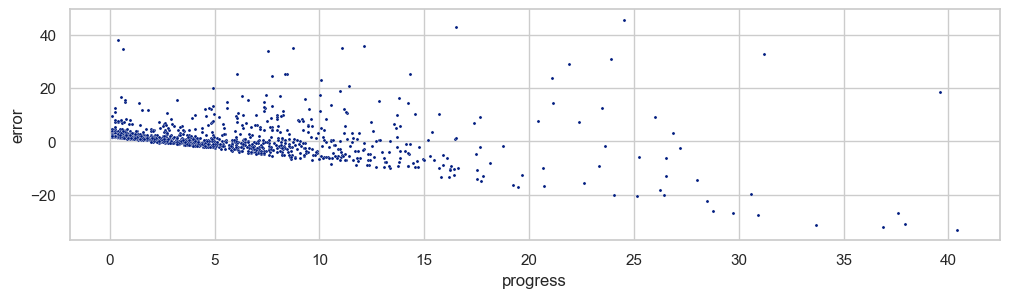

In [45]:
model_df_4f = progress_df3[['lst_event', 'progress', 'near_defender_MPD', 'near_dist', 'SoF', 'has_blocker']]
fit_predict(model_df_4f, robust = False)

<lifelines.CoxPHFitter: fitted with 3731 total observations, 84 right-censored observations>
             duration col = 'progress'
                event col = 'lst_event'
          robust variance = True
      baseline estimation = breslow
   number of observations = 3731
number of events observed = 3647
   partial log-likelihood = -25730.58
         time fit was run = 2024-01-06 15:44:24 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
near_defender_MPD  -0.13       0.88       0.01            -0.15            -0.11                 0.86                 0.90
near_dist          -0.12       0.89       0.01            -0.14            -0.10                 0.87                 0.91
SoF                -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
has_blocker        -0.54       0.58       0.04            -0.63            -0.46                 0.53                 0.63

                    cmp to      z      p   -log2(p)
covariate                                          
near_defender_MPD     0.00 -12.26 <0.005     112.46
near_dist             0.00 -11.42 <0.005      97.90
SoF                   0.00  -8.81 <0.005      59.44
has_blocker           0.00 -12.37 <0.005     114.43
---
Concordance = 0.75
Partial AIC = 51469.15
log-likelihood ratio test = 1369.41 on 4 df
-log2(p) of ll-ratio test = 978.40

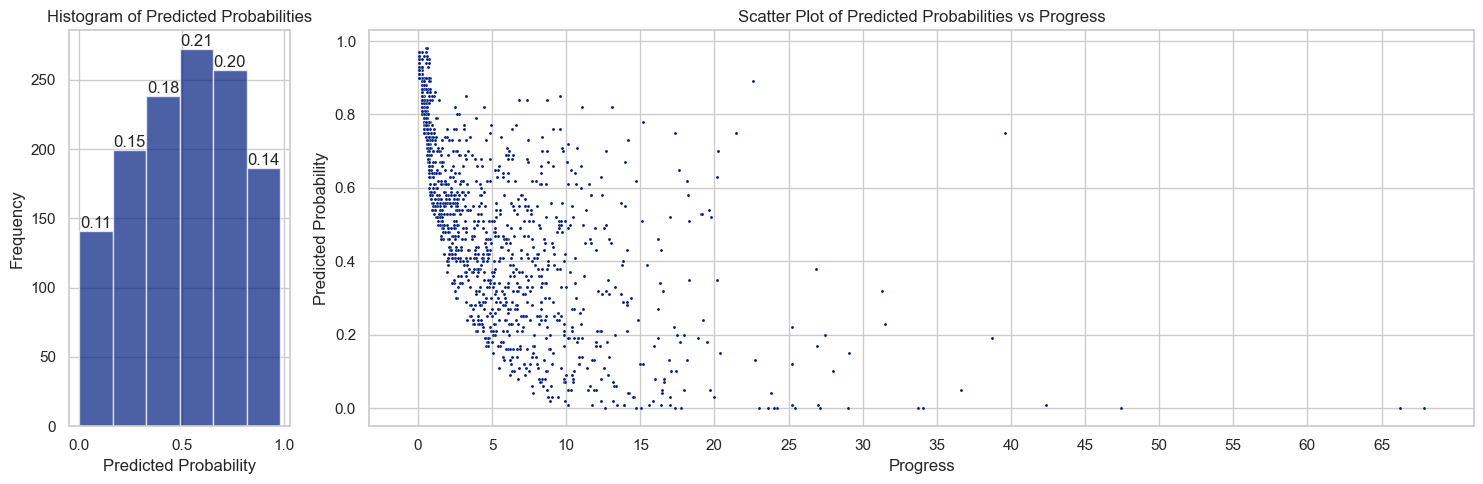

rmse: 7.169065377479161


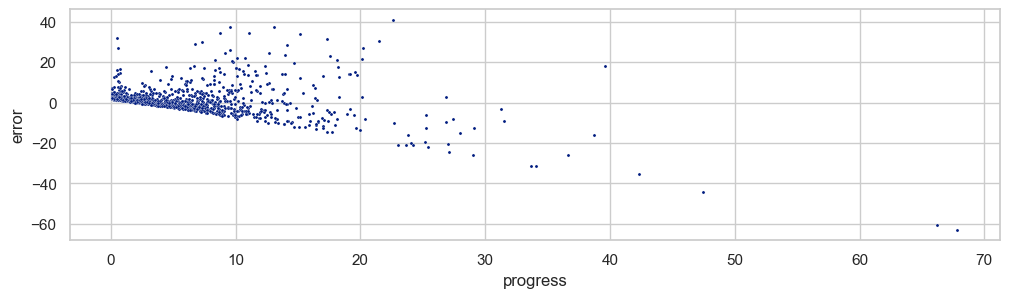

In [46]:
model_df_4f = progress_df3[['lst_event', 'progress', 'near_defender_MPD', 'near_dist', 'SoF', 'has_blocker']]
fit_predict(model_df_4f, robust = True)

Didn't observe significant difference between above models' performance. In addition, the minor differences fluctuates when each model is retained.

In [ ]:
# with open('../saved_models/cph_model.pkl', 'wb') as file:
#     pickle.dump(cph_model, file)